In [ ]:
# Loading Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import  seaborn as sns

#apache spark library
from pyspark.sql import SparkSession

#disapper waening
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#create session to using spark
spark = SparkSession.builder \
    .appName("Spark") \
    .getOrCreate()

In [ ]:
# loading data

import kagglehub

# Download latest version
path = kagglehub.dataset_download("yashdevladdha/uber-ride-analytics-dashboard")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/uber-ride-analytics-dashboard


In [ ]:
import pandas as pd
import os

file_name = os.listdir(path)[0]
file_path = os.path.join(path, file_name)

# Load into pandas
df = spark.read.csv(file_path,header=True, inferSchema=True)

print("✅ Data loaded successfully!")


✅ Data loaded successfully!


In [ ]:
df.show(5)

+----------+-------------------+----------------+---------------+----------------+-------------+-------------------+-----------------+--------+--------+---------------------------+---------------------------------+-------------------------+--------------------------+----------------+-----------------------+-------------+-------------+--------------+---------------+--------------+
|      Date|               Time|      Booking ID| Booking Status|     Customer ID| Vehicle Type|    Pickup Location|    Drop Location|Avg VTAT|Avg CTAT|Cancelled Rides by Customer|Reason for cancelling by Customer|Cancelled Rides by Driver|Driver Cancellation Reason|Incomplete Rides|Incomplete Rides Reason|Booking Value|Ride Distance|Driver Ratings|Customer Rating|Payment Method|
+----------+-------------------+----------------+---------------+----------------+-------------+-------------------+-----------------+--------+--------+---------------------------+---------------------------------+--------------------

In [ ]:
#show schema and tables relations
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Booking ID: string (nullable = true)
 |-- Booking Status: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Vehicle Type: string (nullable = true)
 |-- Pickup Location: string (nullable = true)
 |-- Drop Location: string (nullable = true)
 |-- Avg VTAT: string (nullable = true)
 |-- Avg CTAT: string (nullable = true)
 |-- Cancelled Rides by Customer: string (nullable = true)
 |-- Reason for cancelling by Customer: string (nullable = true)
 |-- Cancelled Rides by Driver: string (nullable = true)
 |-- Driver Cancellation Reason: string (nullable = true)
 |-- Incomplete Rides: string (nullable = true)
 |-- Incomplete Rides Reason: string (nullable = true)
 |-- Booking Value: string (nullable = true)
 |-- Ride Distance: string (nullable = true)
 |-- Driver Ratings: string (nullable = true)
 |-- Customer Rating: string (nullable = true)
 |-- Payment Method: string (nullable = true)



In [ ]:
#desceibe data about mean ,min,max,..
df.describe().show()

+-------+----------------+--------------------+----------------+------------+---------------+-------------+------------------+-----------------+---------------------------+---------------------------------+-------------------------+--------------------------+----------------+-----------------------+------------------+------------------+------------------+------------------+--------------+
|summary|      Booking ID|      Booking Status|     Customer ID|Vehicle Type|Pickup Location|Drop Location|          Avg VTAT|         Avg CTAT|Cancelled Rides by Customer|Reason for cancelling by Customer|Cancelled Rides by Driver|Driver Cancellation Reason|Incomplete Rides|Incomplete Rides Reason|     Booking Value|     Ride Distance|    Driver Ratings|   Customer Rating|Payment Method|
+-------+----------------+--------------------+----------------+------------+---------------+-------------+------------------+-----------------+---------------------------+---------------------------------+----------

In [ ]:
#shape of data
df.count()

150000

In [ ]:
#delete columns have null value in data
df = df.na.drop()
df.count()

150000

In [ ]:
#delete any duplicated value in data
df = df.dropDuplicates()
df.count()

150000

In [ ]:
#change name of columns
df = df.withColumnRenamed("Cancelled Rides by Customer", "Customer_Cancelled") \
       .withColumnRenamed("Cancelled Rides by Driver", "Driver_Cancelled") \
       .withColumnRenamed("Reason for cancelling by Customer", "Customer_Cancel_Reason") \
       .withColumnRenamed("Driver Cancellation Reason", "Driver_Cancel_Reason") \
       .withColumnRenamed("Incomplete Rides Reason", "Incomplete_Reason") \
       .withColumnRenamed("Booking Value", "Fare") \
       .withColumnRenamed("Ride Distance", "Distance")

In [ ]:
#Total trips + success rate
from pyspark.sql.functions import col

total_bookings = df.count()
completed_rides = df.filter(col("Booking Status") == "Completed").count()
success_rate = (completed_rides / total_bookings) * 100

print("📊 Total Bookings:", total_bookings)
print("✅ Completed Rides:", completed_rides)
print("🎯 Success Rate:", success_rate)

📊 Total Bookings: 150000
✅ Completed Rides: 93000
🎯 Success Rate: 62.0


In [ ]:
#Analysis by vehicle type
df.groupBy("Vehicle Type") \
  .agg({"Fare": "sum", "Distance": "avg"}) \
  .show()

+-------------+------------------+-----------+
| Vehicle Type|     avg(Distance)|  sum(Fare)|
+-------------+------------------+-----------+
|         Bike|24.649546283036106|  7837697.0|
|     Go Sedan| 24.60932470793747|  9369719.0|
|      Go Mini|  24.6120899626793|1.0338496E7|
|      Uber XL| 24.40289326765184|  1528032.0|
|         Auto| 24.61599567184734|1.2878422E7|
|Premier Sedan|24.598955745026373|  6275332.0|
|        eBike| 24.99041498398543|  3618485.0|
+-------------+------------------+-----------+



In [ ]:
#Analysis of payment methods
df.groupBy("Payment Method") \
  .count() \
  .orderBy(col("count").desc()) \
  .show()

+--------------+-----+
|Payment Method|count|
+--------------+-----+
|          null|48000|
|           UPI|45909|
|          Cash|25367|
|   Uber Wallet|12276|
|   Credit Card|10209|
|    Debit Card| 8239|
+--------------+-----+



In [ ]:
#Reasons for canceling trips (customers + drivers)
df.groupBy("Customer_Cancel_Reason").count().orderBy(col("count").desc()).show(truncate=False)
df.groupBy("Driver_Cancel_Reason").count().orderBy(col("count").desc()).show(truncate=False)

+--------------------------------------------+------+
|Customer_Cancel_Reason                      |count |
+--------------------------------------------+------+
|null                                        |139500|
|Wrong Address                               |2362  |
|Change of plans                             |2353  |
|Driver is not moving towards pickup location|2335  |
|Driver asked to cancel                      |2295  |
|AC is not working                           |1155  |
+--------------------------------------------+------+

+-----------------------------------+------+
|Driver_Cancel_Reason               |count |
+-----------------------------------+------+
|null                               |123000|
|Customer related issue             |6837  |
|The customer was coughing/sick     |6751  |
|Personal & Car related issues      |6726  |
|More than permitted people in there|6686  |
+-----------------------------------+------+



In [ ]:
#Analyze reviews
df.groupBy("Vehicle Type") \
  .agg({"Customer Rating": "avg", "Driver Ratings": "avg"}) \
  .show()

+-------------+--------------------+-------------------+
| Vehicle Type|avg(Customer Rating)|avg(Driver Ratings)|
+-------------+--------------------+-------------------+
|         Bike|    4.40394043038336|  4.230055579307397|
|     Go Sedan|   4.409996402014869|   4.23181218517629|
|      Go Mini|     4.4042967275864|  4.227694215321538|
|      Uber XL|    4.40485088034495|  4.238339920948614|
|         Auto|   4.401999568127854| 4.2323688188295785|
|Premier Sedan|   4.403457163170995|  4.234864912904368|
|        eBike|   4.403953594871015|  4.225614410013749|
+-------------+--------------------+-------------------+



In [ ]:
#Revenue by month
from pyspark.sql.functions import month, sum as _sum

df.groupBy(month(col("Date")).alias("Month")) \
  .agg(_sum("Fare").alias("Total_Revenue")) \
  .orderBy("Month") \
  .show()

+-----+-------------+
|Month|Total_Revenue|
+-----+-------------+
|    1|    4411069.0|
|    2|    4085790.0|
|    3|    4568188.0|
|    4|    4253789.0|
|    5|    4320679.0|
|    6|    4325660.0|
|    7|    4365923.0|
|    8|    4243509.0|
|    9|    4191393.0|
|   10|    4417170.0|
|   11|    4343395.0|
|   12|    4319618.0|
+-----+-------------+



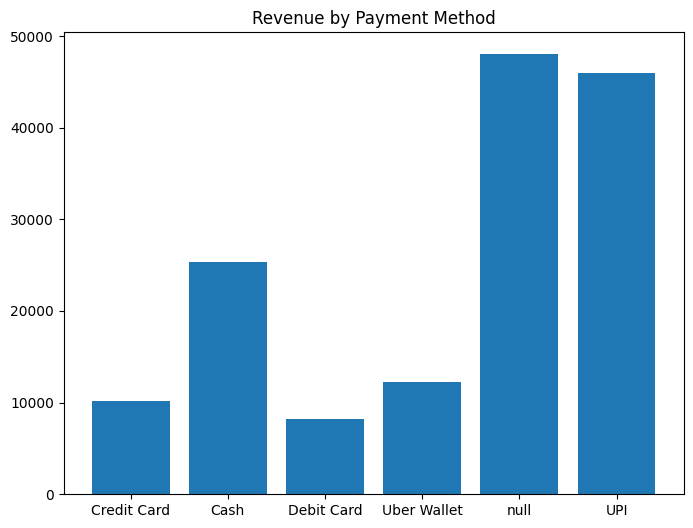

In [ ]:
#Visualization
revenue_by_payment = df.groupBy("Payment Method") \
    .count() \
    .toPandas()

plt.figure(figsize=(8,6))
plt.bar(revenue_by_payment["Payment Method"], revenue_by_payment["count"])
plt.title("Revenue by Payment Method")
plt.show()

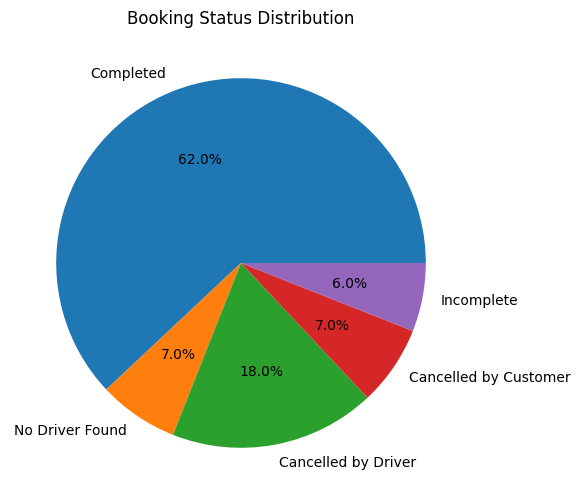

In [ ]:
#Distribution of Booking Status
status_count = df.groupBy("Booking Status").count().toPandas()

plt.figure(figsize=(6,6))
plt.pie(status_count["count"], labels=status_count["Booking Status"], autopct="%1.1f%%")
plt.title("Booking Status Distribution")
plt.show()

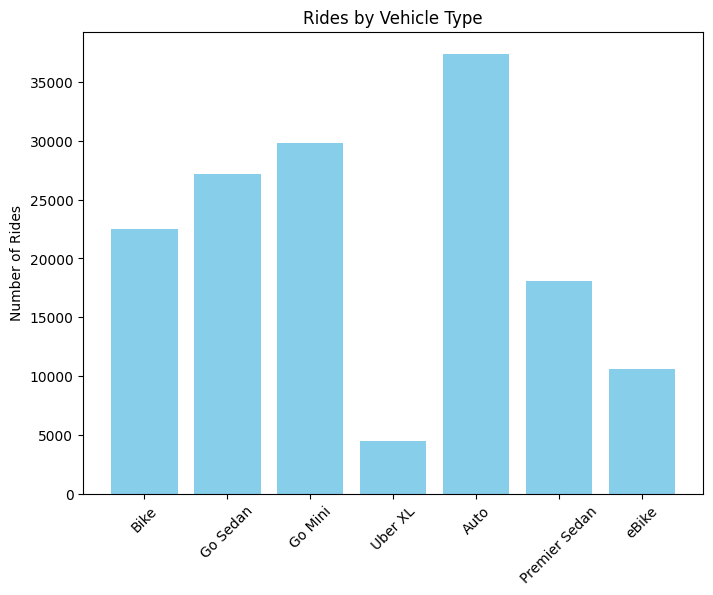

In [ ]:
#Number of trips according to vehicle type
vehicle_count = df.groupBy("Vehicle Type").count().toPandas()

plt.figure(figsize=(8,6))
plt.bar(vehicle_count["Vehicle Type"], vehicle_count["count"], color="skyblue")
plt.title("Rides by Vehicle Type")
plt.xticks(rotation=45)
plt.ylabel("Number of Rides")
plt.show()

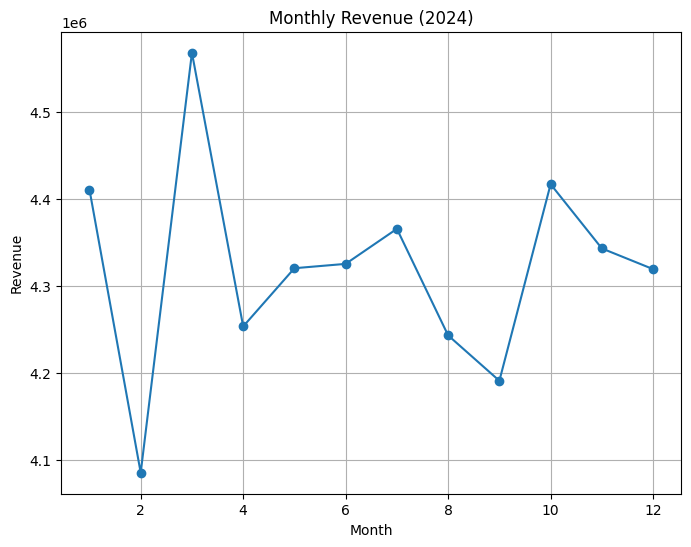

In [ ]:
from pyspark.sql.functions import month, sum as _sum

monthly_revenue = df.groupBy(month(col("Date")).alias("Month")) \
    .agg(_sum("Fare").alias("Total_Revenue")) \
    .orderBy("Month") \
    .toPandas()

plt.figure(figsize=(8,6))
plt.plot(monthly_revenue["Month"], monthly_revenue["Total_Revenue"], marker="o")
plt.title("Monthly Revenue (2024)")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()